> **Results from the best reward experiment.** \
> Comparison uses TD3, SAC, and DSAC with three different reward functions:
> 1. $r=e$
> 1. $r= e + \Delta u$
> 1. $r= e + \Delta u + u$

# ⚙️ Set-up
Loads required packages and set seaborn as plotting style

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np

from helpers.paths import Path
from visualization.utils import make_smooth
sns.set()

Load and adjust data

In [2]:
# Load data
df_learn = pd.read_csv(Path.data/"best_reward_learning.csv")
df_ep = pd.read_csv(Path.data/"best_reward_episode.csv")

df_learn_s = pd.read_csv(Path.data/"best_reward_square_learning.csv")
df_ep_s = pd.read_csv(Path.data/"best_reward_square_episode.csv")

# Rename reward_type
for _df_to_replace in [df_learn, df_ep, df_learn_s, df_ep_s]:
    _df_to_replace["reward_type"].replace({
        "sq_error": r"$e$",
        "sq_error_da": r"$e+\Delta a$",
        "sq_error_da_a": r"$e+\Delta a+a$",
    }, inplace=True)

Make the data from the learning steps smooth

In [3]:
df_learn_smooth = make_smooth(df_learn, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm", "reward_type"])

df_learn_s_smooth = make_smooth(df_learn_s, step=100, 
                              on="global_step", 
                              columns=["rollout/ep_rew_mean", "rollout/ep_len_mean"],
                              info=["algorithm", "reward_type"])

# 👨🏽‍🏫 Learning performance

## Episode length

Comapring the return from different reward functions is not informative. The return from learning is directly linked to how the reward function is designed. However, it is possible to compare the length of the episode throut the learning steps. 

The episode length in a sinusoidal tracking task are:

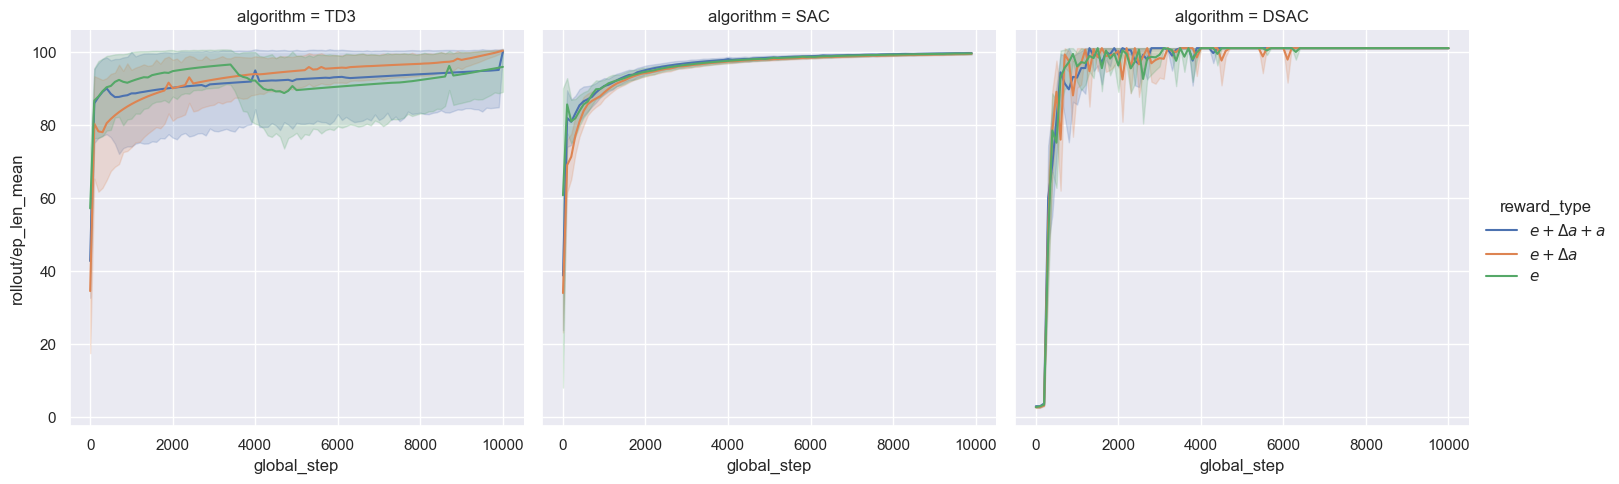

In [4]:
col_order = ["TD3", "SAC", "DSAC"]
g = sns.relplot(data=df_learn_smooth, x="global_step", y="rollout/ep_len_mean", hue="reward_type", kind="line", col="algorithm", col_order=col_order)

The episode length in a squared tracking task is:

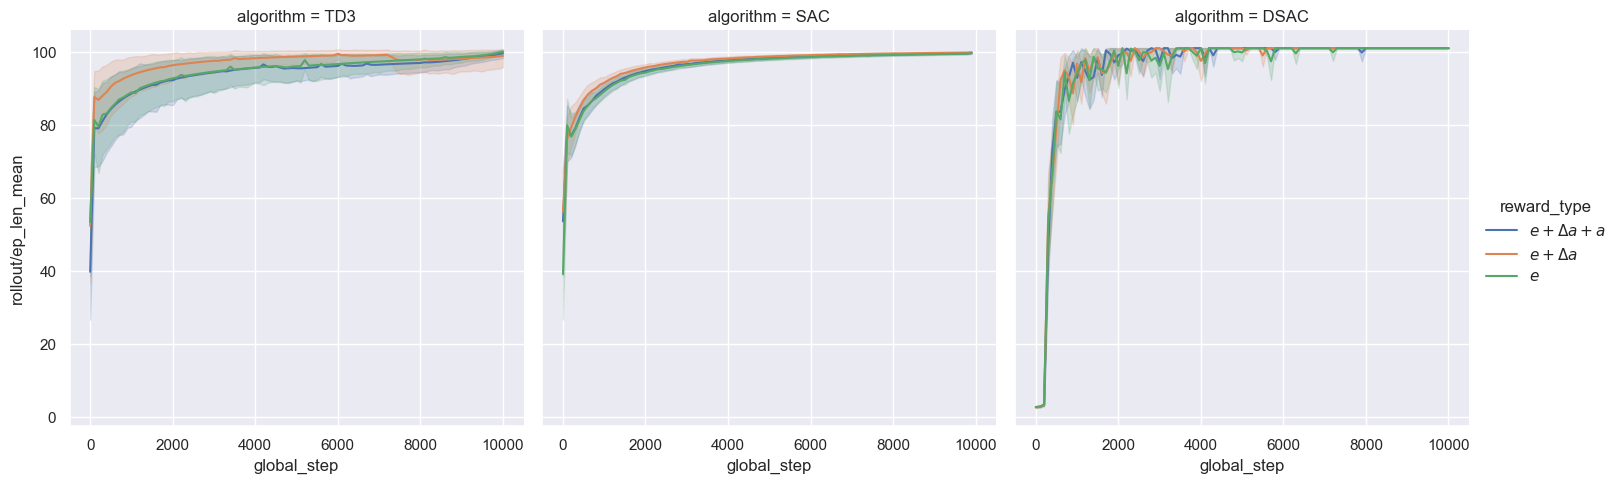

In [5]:
g = sns.relplot(data=df_learn_s_smooth, x="global_step", y="rollout/ep_len_mean", hue="reward_type", kind="line", col="algorithm", col_order=col_order)

Results show that SAC and DSAC are consistant in converging to a maximum episode length under the three types of rewards. TD3, however, shows high variance.

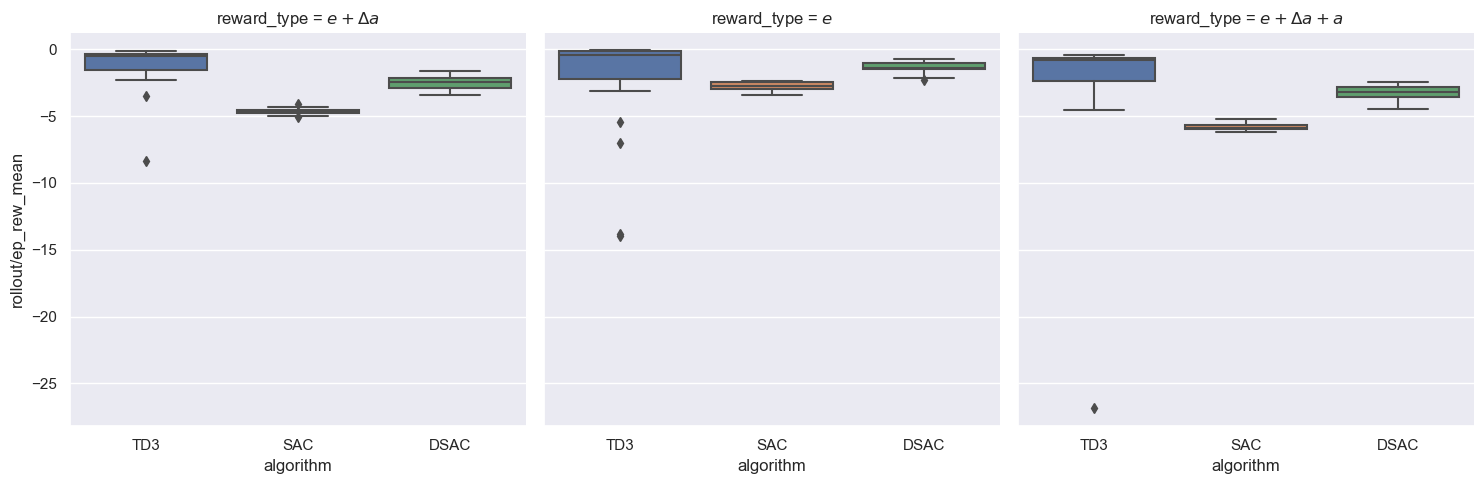

In [6]:
convergence_id = df_learn.groupby(["run"])["global_step"].idxmax().values
sns.catplot(data=df_learn.iloc[convergence_id], x="algorithm", y="rollout/ep_rew_mean", col="reward_type", kind="box", order=col_order);

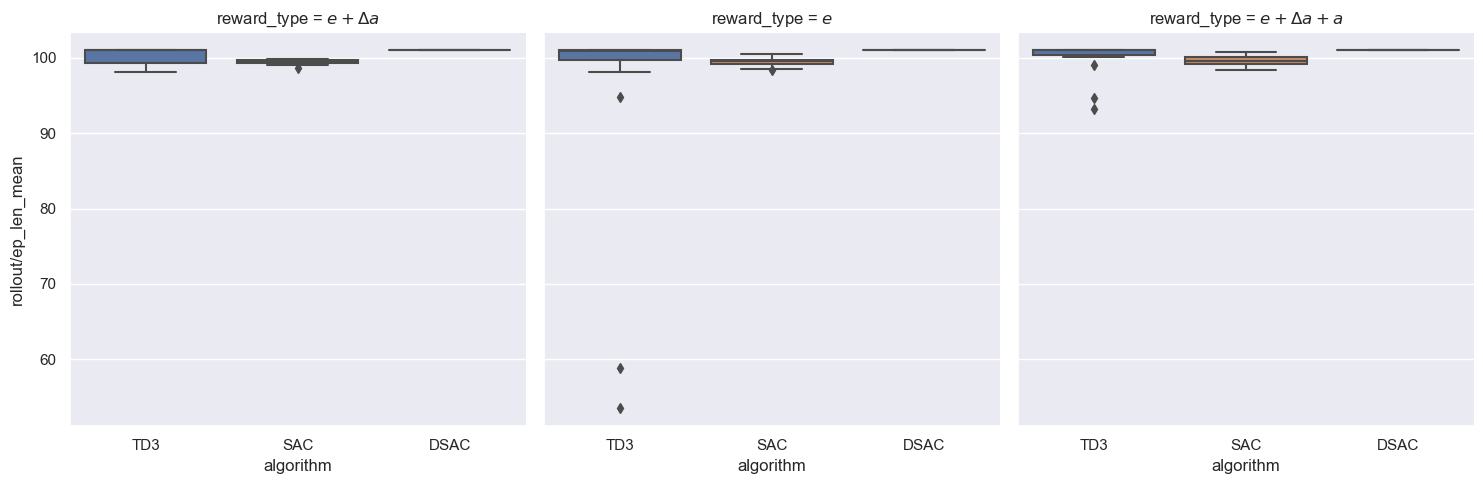

In [7]:
sns.catplot(data=df_learn.iloc[convergence_id], x="algorithm", y="rollout/ep_len_mean", col="reward_type", kind="box", order=col_order);

# 📈 Episode analysis

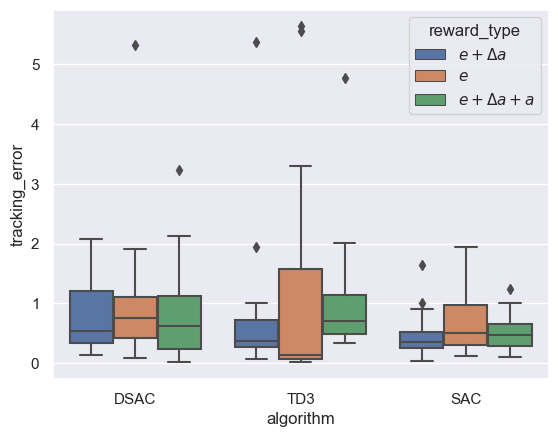

In [8]:
sns.boxplot(data=df_ep.groupby(["run", "algorithm", "reward_type"])["tracking_error"].sum().reset_index(), x="algorithm", y="tracking_error", hue="reward_type");

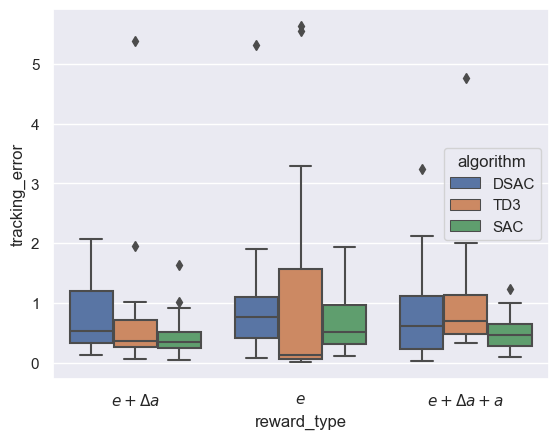

In [27]:
sns.boxplot(data=df_ep.groupby(["run", "algorithm", "reward_type"])["tracking_error"].sum().reset_index(), x="reward_type", y="tracking_error", hue="algorithm");

Two hypothesis:
- TD3 is best and worst.
- DSAC is consistently okay

In [19]:
df_ep["error"] = (df_ep["reference"] - df_ep["state"])**2
df_ep

,Unnamed: 0,episode_step,tracking_error,state,reference,reward,action,algorithm,reward_type,run,error
0,0,0,0.004892,-0.057408,1.253332e-02,-0.013264,0.083721,DSAC,$e+\Delta a+a$,pretty-grass-222,0.004892
1,1,1,0.012015,-0.084743,2.486899e-02,-0.020387,0.052918,DSAC,$e+\Delta a+a$,pretty-grass-222,0.012015
2,2,2,0.014769,-0.084714,3.681246e-02,-0.020060,0.020432,DSAC,$e+\Delta a+a$,pretty-grass-222,0.014769
3,3,3,0.013339,-0.067318,4.817537e-02,-0.016024,-0.003210,DSAC,$e+\Delta a+a$,pretty-grass-222,0.013339
4,4,4,0.009890,-0.040671,5.877853e-02,-0.013387,-0.019087,DSAC,$e+\Delta a+a$,pretty-grass-222,0.009890
...,...,...,...,...,...,...,...,...,...,...,...
17898,95,95,0.010138,0.052511,-4.817537e-02,-0.010138,-0.033374,SAC,$e$,laced-pond-14,0.010138
17899,96,96,0.009769,0.062025,-3.681246e-02,-0.009769,-0.036560,SAC,$e$,laced-pond-14,0.009769
17900,97,97,0.009234,0.071226,-2.486899e-02,-0.009234,-0.038589,SAC,$e$,laced-pond-14,0.009234
17901,98,98,0.008588,0.080139,-1.253332e-02,-0.008588,-0.040759,SAC,$e$,laced-pond-14,0.008588


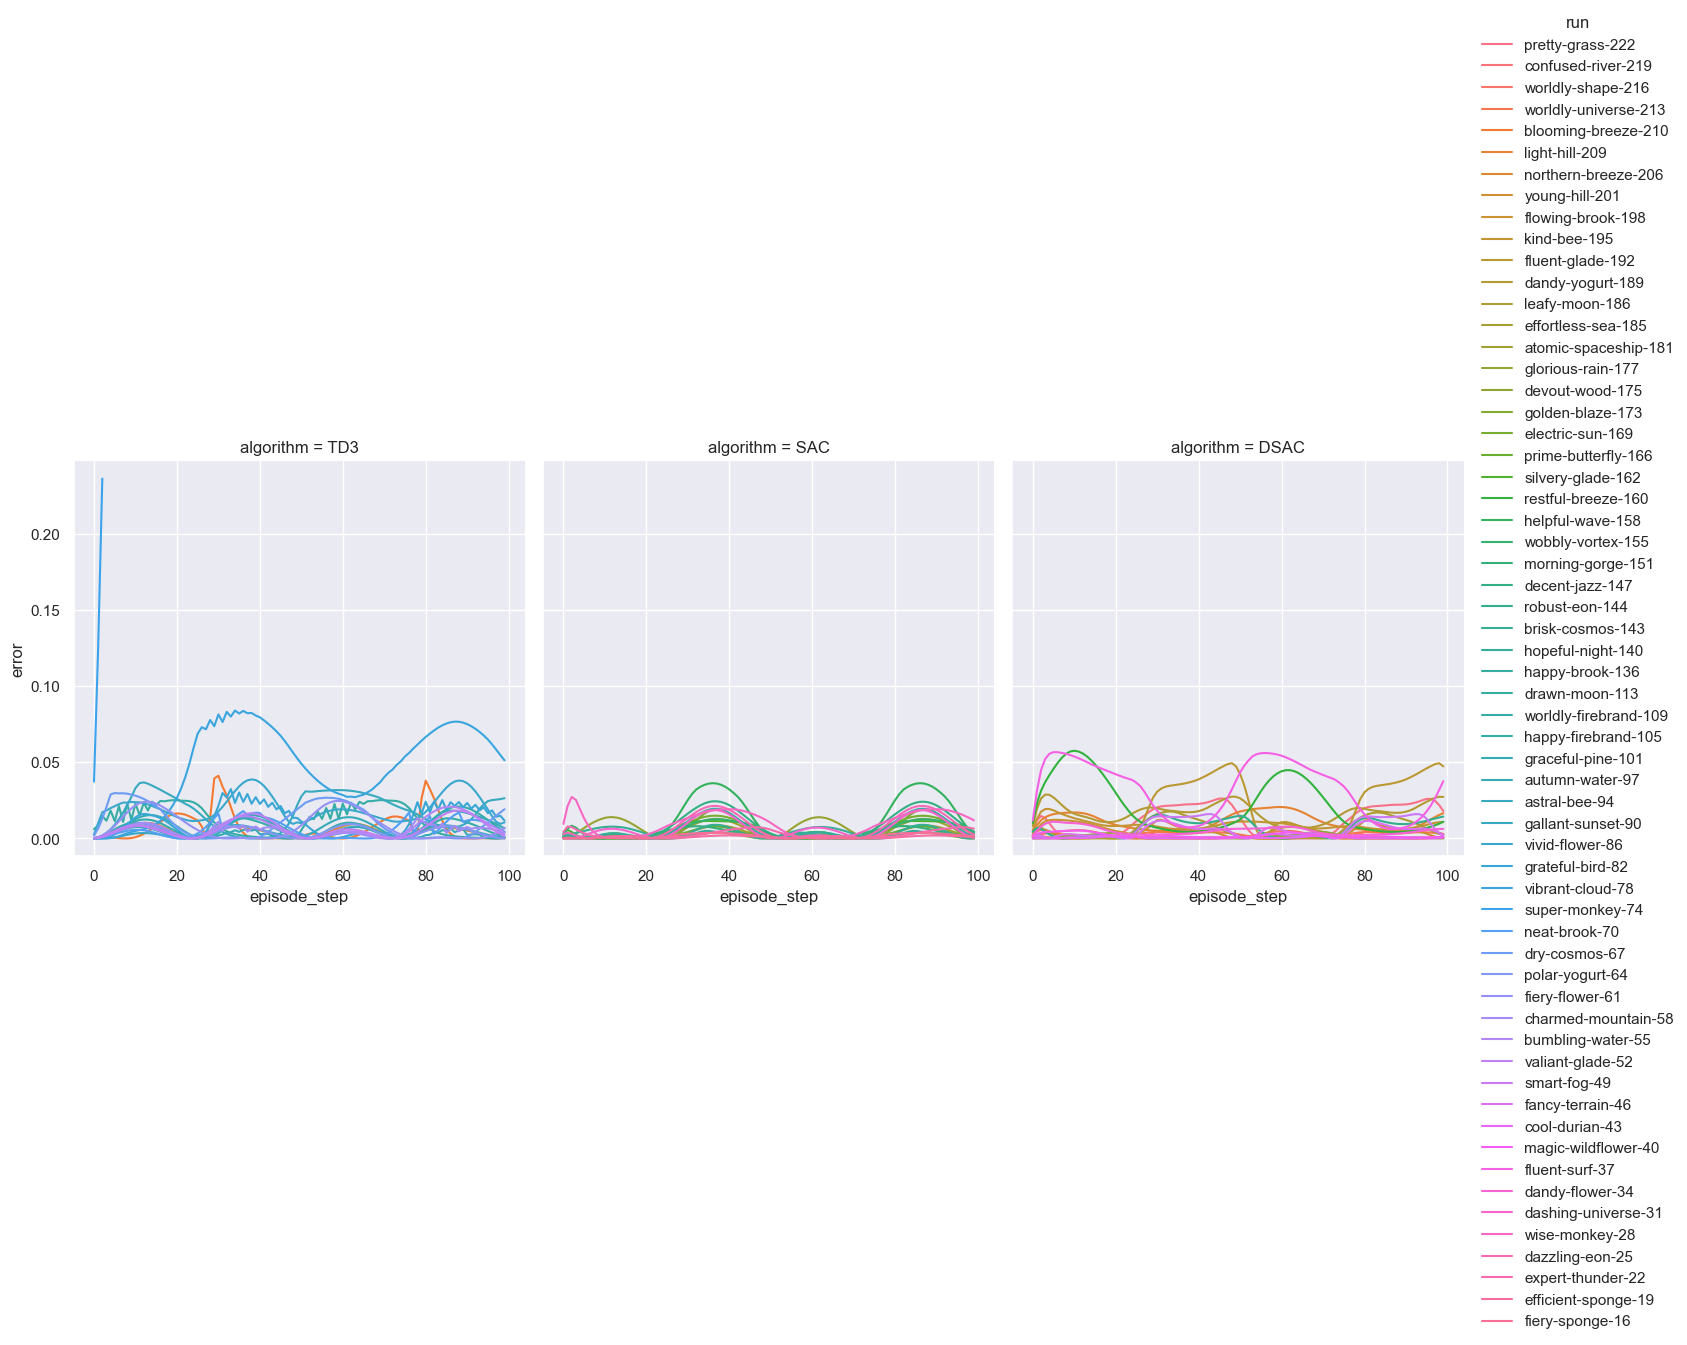

In [26]:
sns.relplot(data=df_ep[df_ep.reward_type==r"$e+\Delta a+a$"], x="episode_step", y="error", col="algorithm", hue="run", col_order=col_order, kind="line")

In [34]:
df_ep[df_ep.episode_step==0]

,Unnamed: 0,episode_step,tracking_error,state,reference,reward,action,algorithm,reward_type,run,error
0,0,0,0.004892,-0.057408,0.012533,-0.013264,0.083721,DSAC,$e+\Delta a+a$,pretty-grass-222,0.004892
100,0,0,0.003226,-0.044268,0.012533,-0.003226,0.064557,DSAC,$e+\Delta a$,fluent-feather-221,0.003226
200,0,0,0.008214,-0.078098,0.012533,-0.008214,0.113894,DSAC,$e$,dainty-dew-220,0.008214
300,0,0,0.000945,-0.018207,0.012533,-0.003600,0.026552,DSAC,$e+\Delta a+a$,confused-river-219,0.000945
400,0,0,0.002491,-0.037379,0.012533,-0.002491,0.054512,DSAC,$e+\Delta a$,honest-cloud-218,0.002491
...,...,...,...,...,...,...,...,...,...,...,...
17403,0,0,0.000061,0.004755,0.012533,-0.000061,-0.006934,SAC,$e+\Delta a$,morning-water-18,0.000061
17503,0,0,0.000009,0.009473,0.012533,-0.000009,-0.013815,SAC,$e$,azure-oath-17,0.000009
17603,0,0,0.000241,0.028053,0.012533,-0.004332,-0.040911,SAC,$e+\Delta a+a$,fiery-sponge-16,0.000241
17703,0,0,0.001983,0.057068,0.012533,-0.001983,-0.083225,SAC,$e+\Delta a$,young-moon-15,0.001983


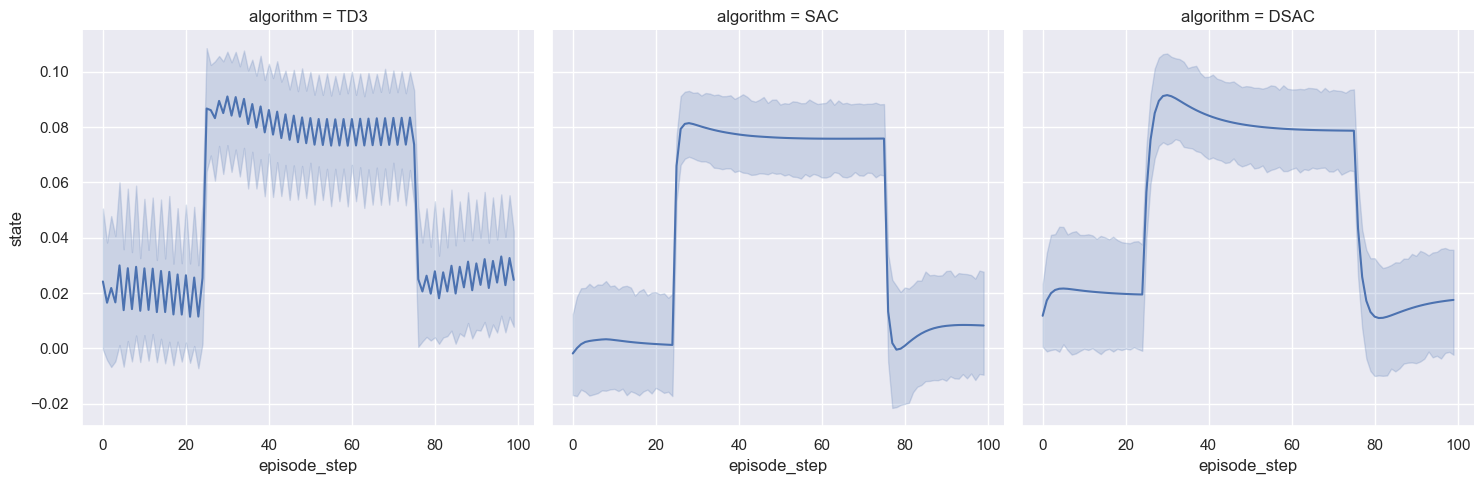

In [10]:
sns.relplot(data=df_ep_s[df_ep_s.reward_type==r"$e$"], x="episode_step", y="state", col="algorithm", col_order=col_order, kind="line")

In [11]:
df_ep.groupby

<bound method DataFrame.groupby of        Unnamed: 0  episode_step  tracking_error     state     reference  \
0               0             0        0.004892 -0.057408  1.253332e-02   
1               1             1        0.012015 -0.084743  2.486899e-02   
2               2             2        0.014769 -0.084714  3.681246e-02   
3               3             3        0.013339 -0.067318  4.817537e-02   
4               4             4        0.009890 -0.040671  5.877853e-02   
...           ...           ...             ...       ...           ...   
17898          95            95        0.010138  0.052511 -4.817537e-02   
17899          96            96        0.009769  0.062025 -3.681246e-02   
17900          97            97        0.009234  0.071226 -2.486899e-02   
17901          98            98        0.008588  0.080139 -1.253332e-02   
17902          99            99        0.007758  0.088077 -2.535885e-15   

         reward    action algorithm     reward_type             